In [40]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json

import regex as re
from python_proj.utils.util import safe_save_fig, subtract_dict, Counter
import python_proj.utils.exp_utils as exp_utils

file_name = "dataset_90_days_started_11_07_23_preprocessed"
base_path = exp_utils.BASE_PATH
data_path = f'{base_path}/final_data/{file_name}.csv'
figure_base_path = f"{base_path}/figures/modelling/{file_name}/"

# Meta stuff.
pr_merged_key = 'PullRequestIsMerged'
ftc_key = 'SubmitterIsFirstTimeContributor'
seed_counter = Counter()


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)
if 'Unnamed: 1' in df.columns:
    df = df.drop(['Unnamed: 1', "Project Name.1"], axis=1)
print(df.columns)

# Creates sub-datasets.
metadata_fields = ['ID', 'Project Name',
                   'Submitter ID', 'PR Number', 'Closed At']
dependent_fields = [pr_merged_key]
independent_fields = [field for field in df.columns
                      if (field not in metadata_fields
                          and field != pr_merged_key)]

df[independent_fields].describe()

class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f'{class_imbalance=}')

meta_header_count = 5

df.describe()

Index(['Project Name', 'ID', 'Submitter ID', 'PR Number', 'Closed At',
       'PullRequestIsMerged', 'ControlIntegratedBySameUser',
       'ControlPullRequestHasComments', 'ControlHasHashTagInDescription',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'EcosystemExperienceSubmitterPullRequestSuccessRate',
       'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate',
       'SubmitterIsFirstTimeContributor',
       'ControlPullRequestHasCommentByExternalUser',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterPullRequestCommentCount)',
       'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + EcosystemExperienceSubmitterPullReques

,ID,Submitter ID,PR Number,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),...,ln(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator),ln(1 + SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter),ln(1 + SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator),ln(1 + SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter),ln(1 + SharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter),ln(1 + SharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator),ln(1 + SharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter),ln(1 + SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter),ln(1 + WeightedFirstOrderInDegreeCentrality),ln(1 + WeightedFirstOrderOutDegreeCentrality)
count,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,...,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06,1.224618e+06
mean,4.074181e-01,8.507216e-02,9.720541e-03,5.030926e-01,4.031614e-01,9.880149e-02,5.957040e-02,4.194410e-01,1.184092e-01,2.985940e-01,...,6.189513e-02,1.412635e-02,5.381418e-02,1.622122e-02,4.480570e-02,2.635940e-02,1.640903e-02,3.945274e-02,8.880002e-02,7.430831e-02
std,2.752979e-01,1.332834e-01,2.771577e-02,4.711048e-01,4.524566e-01,2.910557e-01,2.291380e-01,2.257161e-01,7.146373e-02,1.868728e-01,...,1.373888e-01,6.935800e-02,1.309528e-01,6.848492e-02,1.156639e-01,8.883618e-02,7.432439e-02,1.071170e-01,1.050192e-01,9.857323e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.638131e-01,7.794180e-03,5.905393e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.364583e-01,7.525668e-02,1.658791e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.782989e-01,2.723139e-02,2.386261e-03,6.842105e-01,0.000000e+00,0.000000e+00,0.000000e+00,4.432037e-01,7.525668e-02,2.973351e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.421371e-02,3.547245e-02
75%,6.252435e-01,1.044464e-01,8.231395e-03,1.000000e+00,9.393939e-01,0.000000e+00,0.000000e+00,5.861453e-01,1.505134e-01,4.383688e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.366312e-01,1.118072e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [41]:
import copy

default_plot_settings = {
    'edgecolor': 'black',
    'color': "#e69d00"
}

default_plot_settings_2 = copy.deepcopy(default_plot_settings)
default_plot_settings_2['color'] = "#56b3e9"


def __fix_x_label_fontsize(__column):
    # Adjusts x-label's fontsize to fit the text.
    fig = plt.gcf()
    fig_width = fig.get_figwidth()
    xlabel_fontsize = int(fig_width * 100 / len(__column))
    ax = plt.gca()
    orig_fontsize = ax.xaxis.label.get_fontsize()
    ax.xaxis.label.set_fontsize(min(xlabel_fontsize, orig_fontsize))


def create_histogram(_df: pd.DataFrame, _column: str,
                     subfolder_name: str = "",
                     show_without_value = None):
    can_create_feature_histograms = True

    if not can_create_feature_histograms:
        return

    binary_fields = _df.select_dtypes(exclude='number').columns

    print(_column)
    plt.clf()
    entries = _df[_column]

    if _column in binary_fields:
        entries = _df[_column].replace({False: 0, True: 1})
        plt.xticks([0, 1], ['False', 'True'])
        plt.hist(entries, bins=2, **default_plot_settings)
        plt.ylabel('Frequency')
    # elif __column in shown_fields_without_zeroes:
    elif not show_without_value is None:
        _, bins, _ = plt.hist(entries, bins=30, alpha=1,
                              label="All Data", **default_plot_settings)
        ax: plt.Axes = plt.gca()
        ax.set_ylabel("Frequency")
        ax.set_xlabel(_column)
        __fix_x_label_fontsize(_column)

        filtered_data = _df[_column][_df[_column] != show_without_value]
        ax2 = ax.twinx()

        ax2.hist(filtered_data, bins, alpha=0.5,
                 label=f'Excl. {show_without_value}', **default_plot_settings_2)
        ax2.set_ylabel(f"Frequency (excl. x = {show_without_value})")
        ax2.set_zorder(10)
        plt.tight_layout()
    else:
        plt.hist(entries, bins=30, **default_plot_settings)
        plt.ylabel('Frequency')

    plt.xlabel(_column)
    __fix_x_label_fontsize(_column)
    plt.tight_layout()

    output_path = f"{figure_base_path}/distributions/{subfolder_name}/{_column}.png"
    safe_save_fig(output_path)


In [42]:
binary_values = df['ControlIntegratedBySameUser'].value_counts()
print(binary_values)


ControlIntegratedBySameUser
False    701492
True     523126
Name: count, dtype: int64


1224618
223093
ln(1 + IntraProjectSubmitterIssueSubmissionCount)


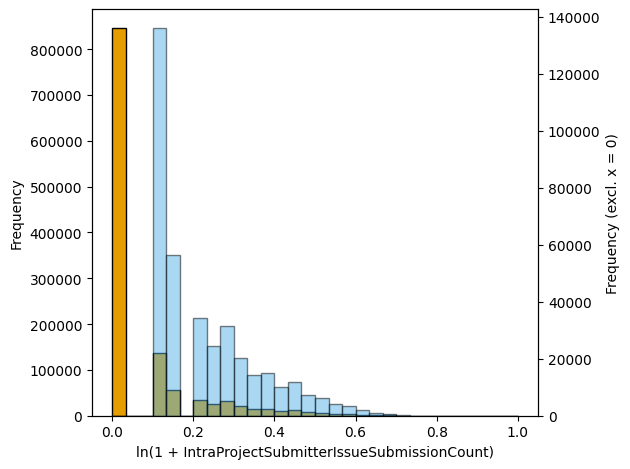

In [50]:
test_df = df[df['ln(1 + IntraProjectSubmitterIssueSubmissionCount)'].lt(np.log(3)).gt(np.log(1))]
print(len(test_df))

dep_ecosystem_fields = [field for field in df.columns[meta_header_count:] if len(list(
    re.findall(r'.*DependencyEcosystem.*', field))) > 0]
dep_ecosystem_df = test_df[test_df[dep_ecosystem_fields].gt(0).any(axis=1)]
print(len(dep_ecosystem_df))

df[['ln(1 + IntraProjectSubmitterIssueSubmissionCount)']].describe()

create_histogram(df, 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'tmp', show_without_value=0)


In [52]:
print(len(test_df))

binary_values = test_df['ControlHasHashTagInDescription'].value_counts()
print(binary_values)
print(binary_values[True] / binary_values[False])

1224618
ControlHasHashTagInDescription
False    822855
True     401763
Name: count, dtype: int64
0.4882549173305139
